In [1]:
import datetime
beg_script = datetime.datetime.now()

# Visualizing the booking history of the UHCW dataset
## Definitions
The **booking history** refers to the status as "available" or "booked" of the appointments in the dataset at the various data collection times.

The **final status** refers to whether an appointment was eventually booked or went unused.
  


## Imports

In [2]:
import os
import sys
PROJECT_DIR = os.path.join(os.path.expanduser("~"), "Projects/UHCW")
PYTHON_DIR = os.path.join(PROJECT_DIR, 'python')
sys.path.insert(0, PYTHON_DIR)

import pytz
import pandas as pd
import UHCW
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [3]:

IMG_DIR = os.path.join(PROJECT_DIR, "IMAGE_FILES")

STATUS_TO_VALUE = {'available': 0, 'booked': 1}

## Helper functions

In [4]:
def write_line_to_desc(col, text, file):
    """Convenience function to add one line, in a particular format,
    to a file recording information on plots saved as images."""
    file.write(
        "{0}{1}{2}\n".format(
            col.ljust(COL_WIDTH),
            VERT_SEP,
            text
        )
    )
def timedelta_strftime(duration):
    """Convenience function to string-format a timedelta."""
    string = "{0} days {1} hours {2} minutes".format(
        duration.days,
        duration.seconds//3600,
        duration.seconds//60
    )
    return string

## Data

In [5]:
%%time
print(datetime.datetime.now().strftime("Time: %H:%M:%S"))
foldername = 'Projects/UHCW/datasets'
# Choose from among datasets of various sizes (various collection periods or centers)
# filename = 'appointments-tiny.csv'
# filename = 'appointments-less-tiny.csv'
filename = 'appointments-one-week-two-centers.csv'
# filename = 'appointments-24-hours.csv'
# filename = 'appointments-one-week.csv'
# filename = 'appointments-three-weeks.csv'
filepath = os.path.join(os.path.expanduser("~"), foldername, filename)

filesize = os.path.getsize(filepath)
if filesize > 1e9:
    print("Size of data file: {}GB.".format(filesize//1e9))
elif filesize > 1e6:
    print("Size of data file: {}MB.".format(filesize//1e6))
elif filesize > 1e3:
    print("Size of data file: {}KB.".format(filesize//1e3))
else:
    print("Size of data file: {}B.".format(filesize))
print("Loading data...")
raw_data = pd.read_csv(filepath, sep=';')


Time: 09:14:48
Size of data file: 187.0MB.
Loading data...
CPU times: user 1.68 s, sys: 139 ms, total: 1.82 s
Wall time: 1.83 s


## The schedule
The dataframe `schedule` is essentially `raw_data` after certain type conversion.  

*(The next cell prints the current time to remember when the following cell was run.)*

In [6]:
print(datetime.datetime.now().strftime("Current time: %Hh %Mm %Ss"))

Current time: 09h 14m 50s


In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2891791 entries, 0 to 2891790
Data columns (total 6 columns):
Unnamed: 0               int64
appointment timestamp    object
center age group         object
center id                int64
test type                object
grab timestamp           object
dtypes: int64(2), object(4)
memory usage: 132.4+ MB


In [8]:
%%time

schedule = UHCW.prepare_UHCW_dataframe(raw_data)

09h14m50s: Make copy of data...
09h14m54s: Type conversion: 
09h14m54s: Column appointment:
09h14m54s: -> convert to datetime...
09h14m54s: -> convert to London timezone...
09h16m37s: Column grab:
09h16m37s: -> convert to datetime...
09h16m38s: -> localize to UTC and convert to London timezone...
CPU times: user 2min 36s, sys: 2.41 s, total: 2min 39s
Wall time: 2min 38s


In [9]:
print(datetime.datetime.now().strftime("End of preprocessing:  %Hh %Mm %Ss"))

End of preprocessing:  09h 17m 29s


## The working schedule

Only consider past appointments (and ignore "age group" info which we won't use):

In [10]:
last_grab = schedule['grab'].max()
s = schedule.query('appointment <= @last_grab').copy()
s.drop('age group', axis=1, inplace=True)

In [11]:
s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 124826 entries, 0 to 1748228
Data columns (total 4 columns):
id             124826 non-null int64
test           124826 non-null object
appointment    124826 non-null datetime64[ns, Europe/London]
grab           124826 non-null datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(1)
memory usage: 4.8+ MB


In [12]:
last_grab

Timestamp('2019-01-22 13:30:00+0000', tz='Europe/London')

## Center info

In [13]:
center_test_types = s.groupby('id')['test'].unique().rename("test types").to_frame()#.reset_index()
center_test_types

,test types
id,
10188,"[Blood Test, INR Test]"
10207,[Blood Test]


## Number of appointments

In [14]:
s.groupby(['id', 'test'])['appointment'].nunique().to_frame()

appointment
id    test                   
10188 Blood Test          438
      INR Test            102
10207 Blood Test          331

## The booking history
The `schedule` contains a row for each appointment available at the times of data collection.
The **booking history** gives the status of the appointment as "available" or "booked" at all data collection times.

In [15]:
%%time
h = UHCW.get_history(s)

09:17:29
Cartesian product grabs by appointments...
Ignore grabs past appointments...
Restrict to past appointments (on or before 2019-01-22 12:01:00+00:00)...
Add status...
CPU times: user 200 ms, sys: 25.3 ms, total: 226 ms
Wall time: 222 ms


## Visualizing the booking history

Plot the booking history for all centers and test types.  

Set `save_figure` to **True** to save plots as image files.
In this case, a brief description of the type of figure is appended to `DESCRIPTION-OF-RUNS.txt`.

10188
Blood Test
INR Test
10207
Blood Test


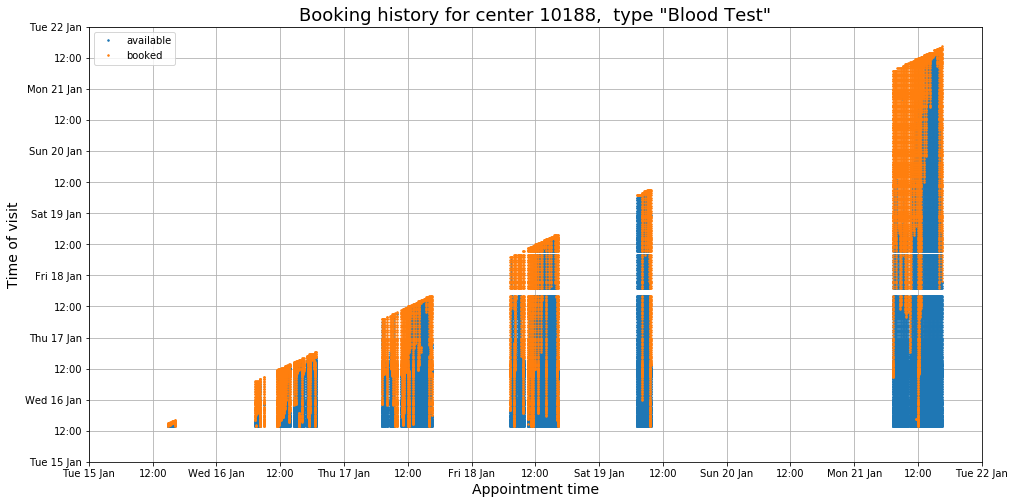

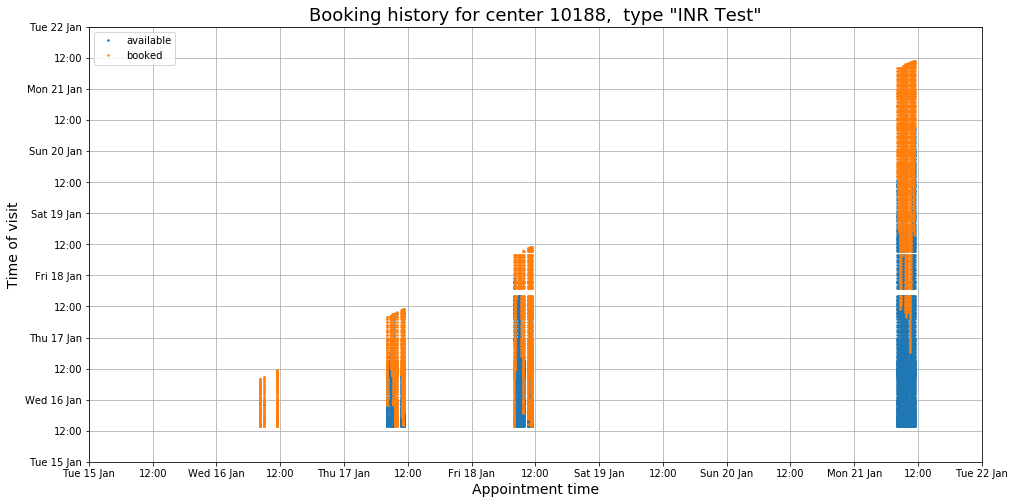

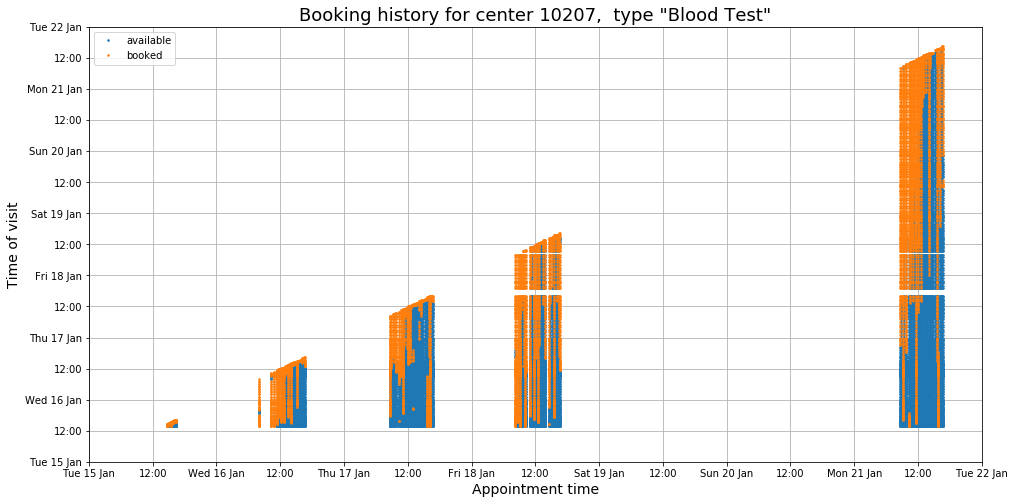

In [32]:
save_figure = False  # True   # 
FIG_SIZE = (16, 8)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "BOOKING HISTORY", descfile)
        write_line_to_desc("Nb rows", f.shape[0], descfile)

        first_grab = h['grab'].min()
        last_grab = h['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = h['appointment'].min()
        last_appointment= h['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)
        
x_date_range, x_tick_labels = UHCW.get_ticks(h['appointment'], freq='D')  # freq='D' 'H'
y_date_range, y_tick_labels = UHCW.get_ticks(h['grab'], freq='D')  # freq='D' 'H'
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        h0 = h.loc[(h['id'] == cid) & (h['test'] == test_type), h.columns]

        if h0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for status in ['available', 'booked']:
            hh0 = h0.loc[
                h0['status'] == status,
                ['appointment', 'grab']
            ].drop_duplicates()
            
            if hh0.empty:
                print(
                    'Remark: no data for status "{0}"'.format(
                    status
                    )
                )
                continue
            else:
                None
            
            legend_text.append(status)
            if status == 'available':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                hh0['appointment'],
                hh0['grab'],
                **{'marker': '.', 'markersize': 3, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='upper left')
        ax.set_title('Booking history for center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_xlim([x_date_range.min(), x_date_range.max()])
        ax.set_yticks(y_date_range);
        ax.set_yticklabels(y_tick_labels);
        ax.set_ylim([y_date_range.min(), y_date_range.max()])
        
        # Save as image file if option was selected
        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-booking-history.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )        

In [17]:
x_date_range.min()

Timestamp('2019-01-15 00:00:00', freq='12H')

In [18]:
x_date_range.max()

Timestamp('2019-01-22 00:00:00', freq='12H')

## Calculating and visualizing the final status
The **final status** refers to whether an appointment was eventually booked or not.  

In [19]:
%%time
f = UHCW.get_final_status(h)

CPU times: user 193 ms, sys: 11.8 ms, total: 205 ms
Wall time: 204 ms


Set `save_figure` to **True** to save plots as image files.
In this case, a brief description of the type of figure is appended to `DESCRIPTION-OF-RUNS.txt`.

10188
Blood Test
Remark: no data for status "available"
INR Test
10207
Blood Test


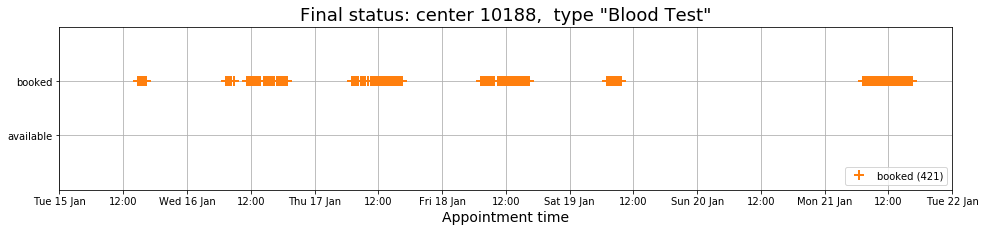

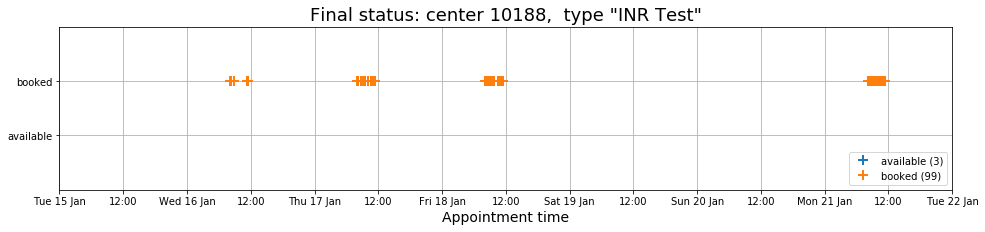

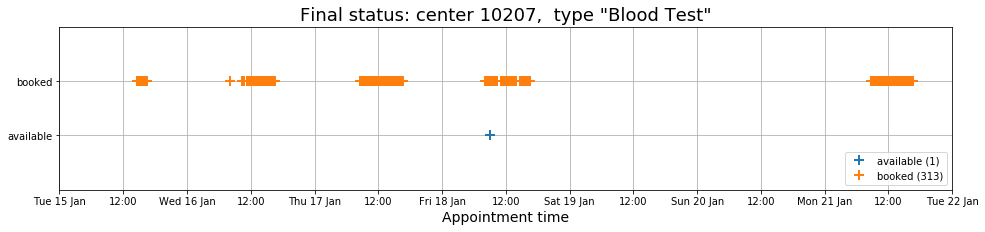

In [30]:
save_figure = False # True  # 
FIG_SIZE = (16, 3)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "FINAL STATUS", descfile)
        write_line_to_desc("Nb rows", f.shape[0], descfile)

        first_appointment = f['appointment'].min()
        last_appointment= f['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)

x_date_range, x_tick_labels = UHCW.get_ticks(f['appointment'], freq='D')   # freq='D' 'H'
# y_date_range, y_tick_labels = UHCW.get_ticks(f['grab'], freq='H')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        f0 = f.loc[(f['id'] == cid) & (f['test'] == test_type), f.columns]

        if f0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for status in ['available', 'booked']:
            ff0 = f0.loc[
                f0['final status'] == status,
                ['appointment']
            ].drop_duplicates()
            
            if ff0.empty:
                print(
                    'Remark: no data for status "{0}"'.format(
                    status
                    )
                )
                continue
            else:
                None
            
            legend_text.append(" ".join([status, "({0})".format(ff0.shape[0])]))
            if status == 'available':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                ff0['appointment'],
                [STATUS_TO_VALUE[status]]*ff0.shape[0],
                **{'marker': '+', 'markersize': 10, 'markeredgewidth': 2, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='lower right')
        ax.set_title('Final status: center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        # ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_yticks([0, 1])
        ax.set_yticklabels(
            [{value: key for key, value in STATUS_TO_VALUE.items()}[idx] for idx in [0, 1]]
        )
        ax.set_ylim([-1, 2])
        ax.set_xlim([x_date_range.min(), x_date_range.max()])

        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-final-status.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )
            
            

## Calculating and visualizing the booking activity  
The **booking activity** refers to whether an appointment is being booked or cancelled.  

In [21]:
%%time
a = UHCW.get_activity(h)

CPU times: user 5.82 s, sys: 66.7 ms, total: 5.89 s
Wall time: 5.78 s


10188
Blood Test
INR Test
10207
Blood Test


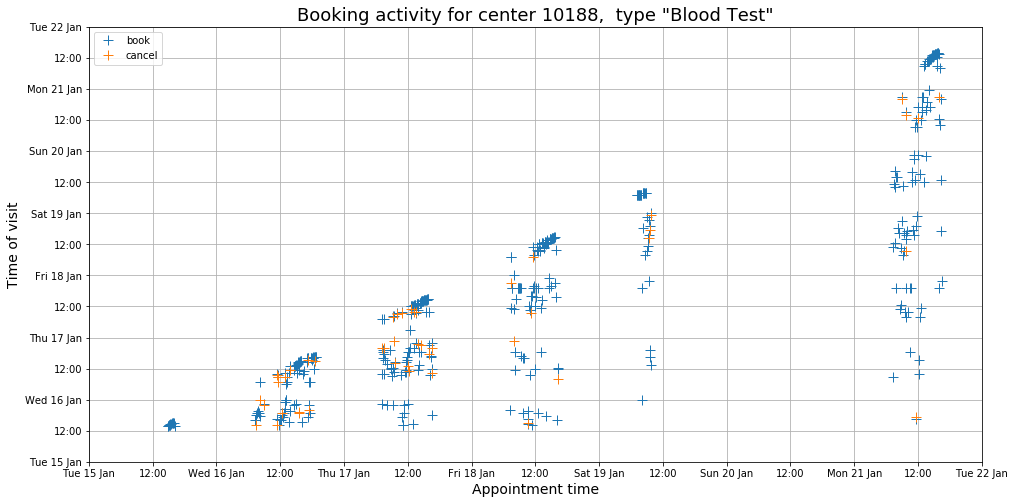

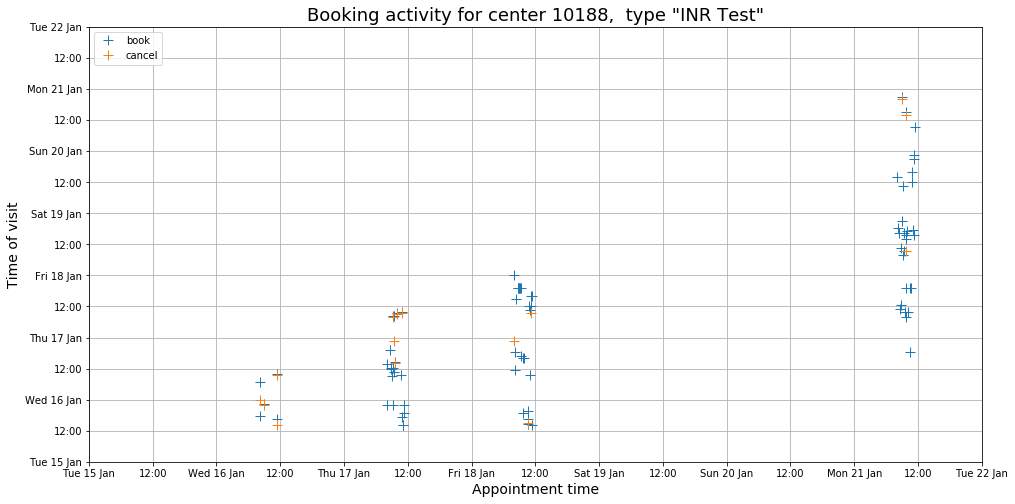

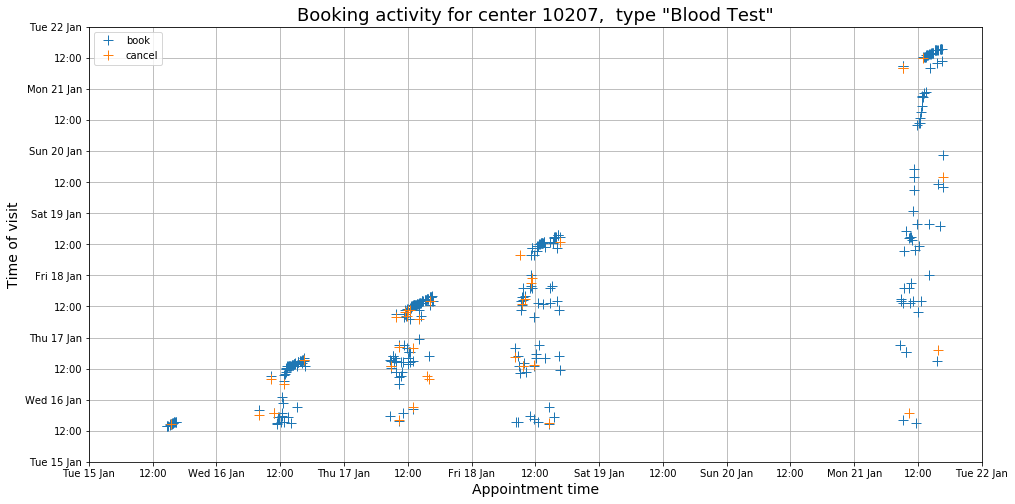

In [31]:
save_figure = False  #  True  #  
FIG_SIZE = (16, 8)

COL_WIDTH = 20
VERT_SEP = ": "

if save_figure:
    RUN_DIR = os.path.join(
        IMG_DIR,
        "-".join(
            ["RUN",
             datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")]
        )
    )
    if not os.path.exists(RUN_DIR):
        os.makedirs(RUN_DIR)
    with open(os.path.join(IMG_DIR, 'DESCRIPTION-OF-RUNS.txt'), 'a') as descfile:
        descfile.write("-"*60 + "\n")
        write_line_to_desc("Run", RUN_DIR, descfile)
        write_line_to_desc("Feature", "BOOKING ACTIVITY", descfile)
        write_line_to_desc("Nb rows", f.shape[0], descfile)

        first_grab = a['grab'].min()
        last_grab = a['grab'].max()
        grab_duration = last_grab - first_grab

        write_line_to_desc("Grab duration", timedelta_strftime(grab_duration), descfile)
        write_line_to_desc("First grab", first_grab, descfile)
        write_line_to_desc("Last grab", last_grab, descfile)

        first_appointment = a['appointment'].min()
        last_appointment= a['appointment'].max()
        appointment_duration = last_appointment - first_appointment

        write_line_to_desc("Appointment duration", timedelta_strftime(appointment_duration), descfile)
        write_line_to_desc("First appointment", first_appointment, descfile)
        write_line_to_desc("Last appointment", last_appointment, descfile)
        
        write_line_to_desc("Figure size", FIG_SIZE, descfile)
        
x_date_range, x_tick_labels = UHCW.get_ticks(a['appointment'], freq='D')
y_date_range, y_tick_labels = UHCW.get_ticks(a['grab'], freq='D')
        


for cid, test_types in center_test_types.iterrows():
    print(cid)
    for test_type in list(test_types)[0]:
        print(test_type)
        a0 = a.loc[(a['id'] == cid) & (a['test'] == test_type), a.columns]
        if a0.empty:
            print(
                "WARNING: no data for center {0}, {1}".format(
                    cid, test_type
                )
            )
            continue
        else:
            None
        
        fig, ax = plt.subplots(figsize=FIG_SIZE)
        
        legend_text = []
        for action in ['book', 'cancel']:
            aa0 = a0.loc[
                a0['action'] == action,
                ['appointment', 'grab', 'action']
            ].drop_duplicates()
            
            if aa0.empty:
                print(
                    'Remark: no data for action "{0}"'.format(
                    action
                    )
                )
                continue
            else:
                None
            
            legend_text.append(action)
            if action == 'book':
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
            else:
                marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
                    
            ax.plot(
                aa0['appointment'],
                aa0['grab'],
                **{'marker': '+', 'markersize': 10, 'markeredgecolor': marker_color, "linestyle": ""}                    
            )
        ax.grid()
        ax.legend(legend_text, loc='upper left')
        ax.set_title('Booking activity for center {0},  type "{1}"'.format(cid, test_type), fontsize=18);
        ax.set_xlabel("Appointment time", fontsize=14);
        ax.set_ylabel("Time of visit", fontsize=14);
        ax.set_xticks(x_date_range);
        ax.set_xticklabels(x_tick_labels);
        ax.set_xlim([x_date_range.min(), x_date_range.max()])
        ax.set_yticks(y_date_range);
        ax.set_yticklabels(y_tick_labels);
        ax.set_ylim([y_date_range.min(), y_date_range.max()])
        
        if save_figure:
            plt.savefig(
                os.path.join(
                    RUN_DIR,
                    'center-{0}-{1}-booking-activity.png'.format(
                        cid,
                        "-".join(test_type.split())
                    )
                )
            )   

In [23]:
end_script = datetime.datetime.now()

run_time = end_script - beg_script

print("This script ran for: {0}min {1}sec.".format(run_time.seconds//60, run_time.seconds%60))

with open(os.path.join(PROJECT_DIR, 'TIMING-OF-RUNS.txt'), 'a') as file:
    # file.write("timestamp,duration (sec),dataset,filesize (KB),first grab,last grab,first appointment,last appointment\n")
    

    file.write(
        ",".join(
            [
                beg_script.strftime("%Y-%m-%d %H:%M:%S"),
                str(run_time.seconds),
                filename,
                str(filesize),
                raw_data['grab timestamp'].min(),
                raw_data['grab timestamp'].max(),
                raw_data['appointment timestamp'].min(),
                raw_data['appointment timestamp'].max()
            ]
        )
    )
    file.write("\n")
    

This script ran for: 2min 52sec.


## Looking up close one test center (and one test type)

In [24]:
import pytz
tz_utc = pytz.timezone("UTC")  # timestamp is in UTC standard
tz_london = pytz.timezone("Europe/London")  # test centers are in Coventry, UK

In [25]:
cid = 10188
test_type = 'Blood Test'

s0 = s.loc[(s['id'] == cid) & (s['test'] == test_type), s.columns]

s0.info()

h0 = UHCW.get_history(s0)
f0 = UHCW.get_final_status(h0)
a0 = UHCW.get_activity(h0)

hh0 = h0[(h0['appointment'] > pd.Timestamp('2019-01-18').tz_localize(tz_london)) & (h0['appointment'] < pd.Timestamp('2019-01-19').tz_localize(tz_london))].copy()

aa0 = a0[(a0['appointment'] > pd.Timestamp('2019-01-18').tz_localize(tz_london)) & (a0['appointment'] < pd.Timestamp('2019-01-19').tz_localize(tz_london))].copy()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63331 entries, 0 to 63330
Data columns (total 4 columns):
id             63331 non-null int64
test           63331 non-null object
appointment    63331 non-null datetime64[ns, Europe/London]
grab           63331 non-null datetime64[ns, Europe/London]
dtypes: datetime64[ns, Europe/London](2), int64(1), object(1)
memory usage: 2.4+ MB
09:17:41
Cartesian product grabs by appointments...
Ignore grabs past appointments...
Restrict to past appointments (on or before 2019-01-22 11:30:00+00:00)...
Add status...


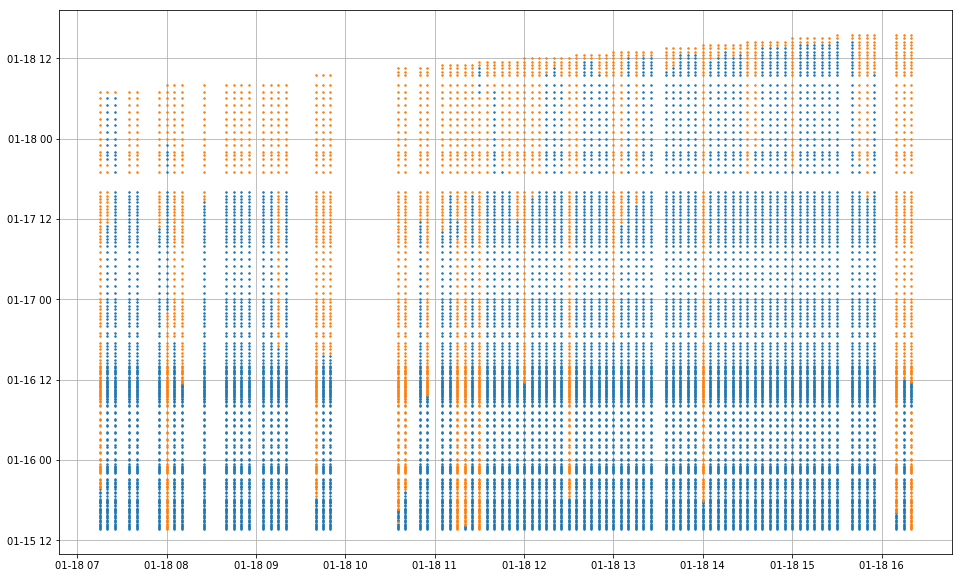

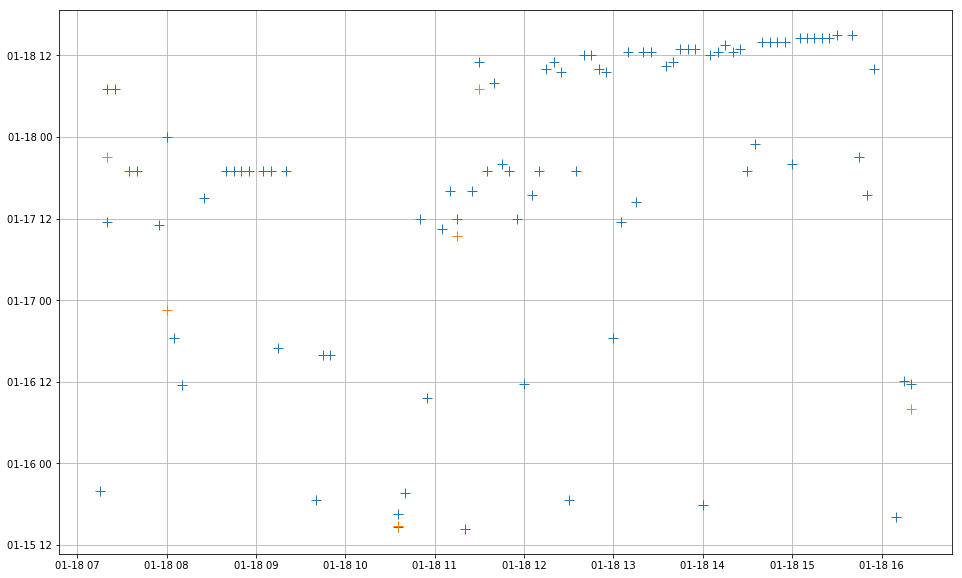

In [26]:
fig_history, ax_history = plt.subplots(figsize=(16, 10));
for status in ['available', 'booked']:
    hhh0 = hh0.loc[
        hh0['status'] == status,
        ['appointment', 'grab']
    ].drop_duplicates()
    
    if hhh0.empty:
        print(
            'Remark: no data for status "{0}"'.format(
            status
            )
        )
        continue
    else:
        None
    
    legend_text.append(status)
    if status == 'available':
        marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    else:
        marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
            
    ax_history.plot(
        hhh0['appointment'],
        hhh0['grab'],
        **{'marker': '.', 'markersize': 3, 'markeredgecolor': marker_color, "linestyle": ""}                    
    )
ax_history.grid()

fig_actvity, ax_activity = plt.subplots(figsize=(16, 10));
for action in ['book', 'cancel']:
    aaa0 = aa0.loc[
        aa0['action'] == action,
        ['appointment', 'grab']
    ].drop_duplicates()
    
    if aaa0.empty:
        print(
            'Remark: no data for action "{0}"'.format(
            action
            )
        )
        continue
    else:
        None
    
    legend_text.append(action)
    if action == 'book':
        marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
    else:
        marker_color = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
            
    ax_activity.plot(
        aaa0['appointment'],
        aaa0['grab'],
        **{'marker': '+', 'markersize': 10, 'markeredgecolor': marker_color, "linestyle": ""}                    
    )
ax_activity.grid()